In [251]:
# import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

# import libs
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from sklearn.linear_model import Lasso, LogisticRegression
# from sklearn.metrics import accuracy_score,make_scorer, mean_squared_error, mean_absolute_error,

from sklearn import datasets, linear_model, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


import scikitplot as skplt
import matplotlib.pyplot as plt

## I. Introduction

https://www.kaggle.com/henriqueyamahata/bank-marketing

### Input variables:
* Bank client data:
   1. age (numeric)
   2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   5. default: has credit in default? (categorical: "no","yes","unknown")
   6. housing: has housing loan? (categorical: "no","yes","unknown")
   7. loan: has personal loan? (categorical: "no","yes","unknown")
* Related with the last contact of the current campaign:
   8. contact: contact communication type (categorical: "cellular","telephone") 
   9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
   11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* Other attributes:
   12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
   14. previous: number of contacts performed before this campaign and for this client (numeric)
   15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
* Social and economic context attributes
   16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
   17. cons.price.idx: consumer price index - monthly indicator (numeric)
   18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
   19. euribor3m: euribor 3 month rate - daily indicator (numeric)
   20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
  21. y - has the client subscribed a term deposit? (binary: "yes","no")

### Missing Attribute Values:
There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 


## I. Introduction

## II. DATA UNDERSTANDING

In [428]:
# get data banking marketing from file
file_path = "data/bank-additional-full.csv"
marketing_df = pd.read_csv(file_path,sep = ";")
marketing_df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
def visualize_numerical(df, column, target = None):

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3));

    sns.histplot(df[column], ax=ax1, kde=True);
    ax1.set_xlabel(column);
    ax1.set_ylabel('Density');
    ax1.set_title(f'{column}  Distribution');
    
    if(target == None):
        sns.boxplot(y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_ylabel(column);
    else:
        sns.boxplot(x=target, y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_xlabel('Target');
        ax2.set_ylabel(column);
    
    plt.show()

def visualize_numerical_lst(df, numerical = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',\
                            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], target = None):
    for column in numerical:
        visualize_numerical(df,column, target)
        print();
        
        
def visualize_categorical(df, column, target = 'y'):
    
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,4))    
        data1 = df.groupby(column).size()
        ax1.pie(x=data1 , autopct="%.2f%%", explode=[0.05]*len(data1), labels=data1.index.tolist(),pctdistance=0.5, radius=1.1)
        ax1.set_title(f'{column}  Distribution')

        data2 = get_col_target(column, target,df)   
        data2.plot(kind='bar',stacked = True, ax=ax2);
        plt.xticks(rotation=45);
        
        plt.show()
    
    
def visualize_categorical_lst(df,categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',\
                                          'month', 'day_of_week', 'poutcome'], target = 'y'):
    
    
    for column in categorical:
        visualize_categorical(df, column)
        
def get_col_target(rows, cols,data):
    
    cols_lst = data[cols].unique().tolist()
    rows_lst = data.groupby(rows)[rows].count().sort_values(ascending = False).index.tolist()

    group_df = data.groupby([rows,cols]).size()
    dic = {}
    for item in cols_lst:
        vals = []
        for i in rows_lst:
            try:
                vals.append(group_df.loc[(i, item)])
            except:
                vals.append(0)
            finally:
                continue
        dic[item] = vals

    df = pd.DataFrame(dic,index = rows_lst)
    return(df)


### Những chú ý cho quá trình xử lý

1. Lược bỏ dữ liệu
* Cột 'duration' sẽ không được quan tâm trong quá trình phân tích và xử lý
* Có 12 dòng trùng nhau sẽ cắt bỏ
2. Missing:
* các giá trị unknown của các cột khác: loan, housing, default, marital, job
3. Outlier:
* Age, campain, previous, cons.conf.idx
4. Phân loại lại biến pdays, age
5. Clustering theo 3 chỉ số pdays,previous,poutcome
6. Sự tương quan giữa các biến:
* 3 biến nr.employed, emp.var.rate, euribo3m là 3 biến có tương quan rất mạnh --> có thể lọc bớt để giảm chiều dữ liệu

### Cách xử lý
1. Xóa 12 dòng dữ liệu trùng nhau
2. Loại bỏ cột duration, nr.employed
3. Biến 'default': khoảng 20% biến này có giá trị 'unknown' - không xác định đc là client có tín dụng xấu hay không - (yes) hay (no).
> Vì đa số biến này cũng khó xác định nên ta sẽ không biến đổi thuộc tính này

MISSING
4. 2. Biến 'education': 4% là unknown
> Thay thế giá trị 'unknown' --> 'university-degree'(bằng giá trị mode của cột dữ liệu)
5. Biến 'loan' và 'housing': 
    * Tỉ lệ missing khá nhỏ: là 2.4% (unknown)
    * Cách xử lý: mục tiêu là càng tiếp thị càng nhiều khách hàng càng tốt, ta đánh vào các giá trị mà tỉ lệ sucessful cao:
        - loan : unknown --> no
        - housing: unknown --> yes
6. Biến marital:missing rất thấp 0.1%
> unknown --> single
7. Biến job: missing thấp 0.8
> unknown --> student

OUTLIER
8. (I). age: thay thế những giá trị > 70 bằng 70
Nhìn biểu đồ thấy sau 70 là outlier
9. (II). campain: thay thế những giá trị > quantile_95 bằng quantile_95
10. (III). previous: thay thế những giá trị > quantile_95 bằng quantile_95
11. (IV). cons.conf.idx: thay thế những giá trị > quantile_95 bằng quantile_95

Phân loại lại biến
12. (I). Column 'pdays'
* Có đến 96.3% bộ dữ liệu thuộc tính 'pdays' có giá trị '999' - ghi nhận lại đây là những khách hàng chưa được liên hệ bằng call trước đó.
> Vì vậy đối với biến này, ta sẽ biến đổi phân loại thành 3 nhóm: 'not_previously_contacted', 'within_a_week', 'over_a_week'

## III. D A T A PROCESSING

In [443]:
def remove_duplicated_row(df):
    df = df.drop(df[df.duplicated()].index).reset_index(drop=True)
    return(df)

def remove_features(df,col_lst):
    for col in col_lst:
        df.pop(col)
    return(df)

def replace_missing_by_value(df,column,replaced_value,missing_value='unknown'):
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    return df

def replace_outlier_by_quantile(df, column, quantile_thresh = 0.95, replaced_value = None):
    thresh_value = df[column].quantile(quantile_thresh)
    if (replaced_value == None):
        replaced_value = thresh_value
        
    df[column] = df[column].apply(lambda val: replaced_value if val > thresh_value  else val)
    return df

def replace_outlier_by_value(df, column, value_thresh, replaced_value = None):
    if (replaced_value == None):
        replaced_value = value_thresh
        
    df[column] = df[column].apply(lambda val: replaced_value if val > value_thresh else val)
    return df

def replace_missing_by_mode(df,column,missing_value='unknown'):
    replaced_value = df[column].mode().values.tolist()[0]
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    
    return df

def replace_missing_by_median(df,column,missing_value='unknown'):
    replaced_value = df[column].median().values.tolist()[0]
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    return df

def transform_pdays(val):
    transform_dict = {999:'not_previously_contacted',7: 'over_a_week',0:'within_a_week'}
    for key in transform_dict.keys():
        if (val >= key):
            return transform_dict[key]
        
def data_processing_pipeline(df):
    # edu_unknown = 'unknown'
    column = 'education'
    replaced_value = df[column].mode().values.tolist()[0]
    replace_missing_by_value(df,column,replaced_value)

    # housing_unknown = 'unknown'
    column = 'housing'
    replaced_value  = 'yes' #df[column].mode().values.tolist()[0]
    replace_missing_by_value(df,column,replaced_value)

    # loan_unknown = 'unknown'
    column = 'loan'
    replaced_value  = 'no' # df[column].mode().values.tolist()[0]
    replace_missing_by_value(df,column,replaced_value)

    # marital_unknown = 'unknown'
    column = 'marital'
    replaced_value  = 'single' # df[column].mode().values.tolist()[0]
    replace_missing_by_value(df,column,replaced_value)

    # job_unknown = 'unknown'
    column = 'job'
    replaced_value  = 'student' # df[column].mode().values.tolist()[0]
    replace_missing_by_value(df,column,replaced_value)

    ## OUTlier
    # age
    value_thresh = 65
    column = 'age' 
    replace_outlier_by_value(df,column,value_thresh)

    # campain
    value_thresh = 6
    column = 'campaign' 
    replace_outlier_by_value(df,column,value_thresh)

    #previous
    remove_thresh = float(0.95)
    column = 'previous' 
    replace_outlier_by_quantile(df,column)

    #cons.conf.idx'
    remove_thresh = float(0.95)
    column = 'cons.conf.idx' 
    replace_outlier_by_quantile(df,column)

    ### PHÂN LOẠI LẠI BIẾN
    # pdays
    column = 'pdays'
    df[column] = df[column].map(transform_pdays)
    
    return df

In [455]:
process_mkt_df = marketing_df.copy() 
marketing_df = data_processing_pipeline(process_mkt_df)

In [404]:
# # visulize dữ liệu
# categorical = process_mkt_df[main_features].dtypes[process_mkt_df[main_features].dtypes == 'object'].index.tolist()
# numerical = process_mkt_df[main_features].dtypes[process_mkt_df[main_features].dtypes != 'object'].index.tolist()

# # categorical = categorical.append('process_previous')
# # numerical = numerical.remove('process_previous')

# visualize_numerical_lst(model_mkt_df,numerical, target = None)
# # Visualization các biến numerical:

In [406]:
# visualize_categorical_lst(model_mkt_df, categorical)

# # Visualization các biến numerical:

In [407]:
# visualize_success_rate(model_mkt_df, categorical)

### Label encoding

In [457]:
categorical = process_mkt_df.dtypes[process_mkt_df.dtypes == 'object'].index
numerical = process_mkt_df.dtypes[process_mkt_df.dtypes != 'object'].index

labelencoder = LabelEncoder()
for column in categorical:
    process_mkt_df[column] = labelencoder.fit_transform(process_mkt_df[column])

In [458]:
process_mkt_df['y'].tail(5)

41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, dtype: int32

### Split Train & Test Data: 70% Train - 30% Test

In [276]:
X_train, X_test, y_train, y_test = train_test_split(model_mkt_df.drop('y',axis=1), model_mkt_df['y'],
                                                    test_size=0.3, random_state = 101)
#                                                     stratify= df['y'])

### Normalize

In [277]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## IV. M O D E L I N G

In [354]:
def eval_class(true, predicted):
    acc = metrics.accuracy_score(true, predicted)
    precision = metrics.precision_score(true, predicted)
    recall = metrics.recall_score(true, predicted)
    f1 = metrics.f1_score(true, predicted)
    log_loss = metrics.log_loss(true, predicted)
    auc = metrics.roc_auc_score(true, predicted)
    return acc, precision, recall, f1, log_loss, auc

def create_evaluation_df(model_name, y_train,y_train_pred, y_test, y_test_pred):
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
  
    res_clm = pd.DataFrame(data=[[model_name,*eval_class(y_train,y_train_pred),
                                 *eval_class(y_test, y_test_pred)]],
                          columns=['Model'] + eval_clm_train + eval_clm_test)
    res_clm['diff_Acc_train_test'] = res_clm.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
    return(res_clm[dis_clm])

def init_evaluation_df():
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
    
    res_clm = pd.DataFrame( columns=['Model'] + eval_clm_train + eval_clm_test + ['diff_Acc_train_test'])

    return(res_clm[dis_clm])

def run_mode(model):
    model.fit(X_train, y_train)
    
    # Prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print('classification_report')
    print(classification_report(y_test,y_pred))
    print()
    print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test,y_test_pred)))
    print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_train_pred)))
    

In [385]:
### R U N M O D E Ls
evalutation_df = init_evaluation_df()
y_test_proba_df = pd.DataFrame()

models = [LogisticRegression(max_iter = 300),
          GaussianNB(),
          DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0),
          RandomForestClassifier(n_estimators=1000, max_depth=3),
          GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01),
          XGBClassifier(n_estimators=1000, learning_rate=0.05, use_label_encoder = False)
          ]

names = [ 'Logistic Regressor',
          'Naive Bayes',
            'Decision Tree Classifier',
          'Random Forest Classifier',
          'Gradient Boost Classifier',
          'XGBoost Classifier'
        ]

for model,name in zip(models,names):
    model.fit(X_train,y_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:,1] #Lấy xác suất phần 1
    y_train_pred = model.predict(X_train)
    
    model_eval_df = create_evaluation_df(name, y_train,y_train_pred, y_test, y_test_pred)
    evalutation_df = evalutation_df.append(model_eval_df, ignore_index = True)
    y_test_proba_df[name] = y_test_pred_proba
    


[07:49:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [358]:
### EVALUATION
evalutation_df 

,Model,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test,Log_loss_test,AUC_test,diff_Acc_train_test
0,Logistic Regressor,0.900219,0.900348,0.705100,0.224576,0.340653,3.441864,0.606208,0.000144
1,Naive Bayes,0.821150,0.821582,0.303393,0.429379,0.355556,6.162437,0.650869,0.000526
2,Decision Tree Classifier,0.900045,0.898405,0.704835,0.195621,0.306247,3.508966,0.592508,-0.001822
3,Random Forest Classifier,0.899351,0.897920,0.728614,0.174435,0.281481,3.525740,0.583012,-0.001592
4,Gradient Boost Classifier,0.905839,0.900267,0.663701,0.263418,0.377149,3.444663,0.623069,-0.006151
5,XGBoost Classifier,0.942303,0.893224,0.567268,0.288842,0.382780,3.687922,0.630157,-0.052084


In [396]:
['base line']+ y_test_proba_df.columns.tolist()

['base line',
 'Logistic Regressor',
 'Naive Bayes',
 'Decision Tree Classifier',
 'Random Forest Classifier',
 'Gradient Boost Classifier',
 'XGBoost Classifier']

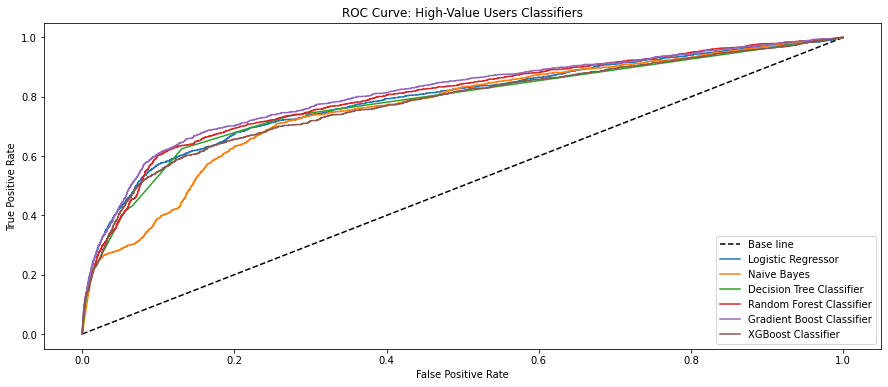

In [397]:
### ROC CURVE

plt.figure(figsize = (15,6))
plt.plot([0, 1], [0, 1], 'k--')

# Generate ROC curve values: fpr, tpr, thresholds
for col in y_test_proba_df.columns:
    fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_test_proba_df[col])
    plt.plot(fpr1, tpr1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: High-Value Users Classifiers')
plt.legend(['Base line']+ y_test_proba_df.columns.tolist(), loc='lower right')
plt.show()

In [398]:
model = LogisticRegression(max_iter = 300)
model.fit(X_train, y_train)
# Prediction
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_probs = model.predict_proba(X_test)
#     Confusion Matrix
#     metrics.confusion_matrix(y_test_pred, y_test)
#     classification_report
# print('classification_report')
# print(classification_report(y_test,y_test_pred))

print(classification_report(y_test,y_test_pred))
# print()
# print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test,y_test_pred)))
# print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_train_pred)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10937
           1       0.71      0.22      0.34      1416

    accuracy                           0.90     12353
   macro avg       0.81      0.61      0.64     12353
weighted avg       0.88      0.90      0.88     12353



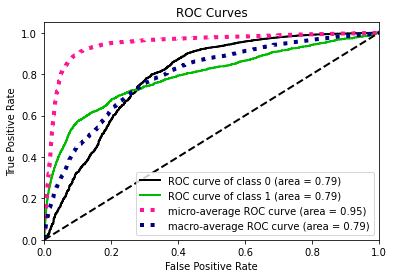

In [384]:
### ROC CURVE 
#!pip install scikit-plot

import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_true = y_test,y_probas = y_probs )
plt.show()

In [243]:
# # 3. Hệ số mô hình
# logmodel.coef_
# mode.feature_importances

In [403]:
evaluation_df.Model.values.tolist()

[]

###  ANN Model
Chưa chạy được

In [120]:
#!pip install keras

In [124]:
#!pip install tensorflow

In [125]:
import keras
from keras.models import Sequential
from keras.layers import Dense

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [ ]:
model = Sequential()
model.add(Dense(input_dim = 2, units = 10, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units = 20, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units = 1, activation='sigmoid', kernel_initializer='uniform'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train,y_train,batch_size=500, epochs=10)
model.evaluate(X_test,y_test)
model.evaluate(X_train,y_train)